In this notebook we use the randomforest to predict feature importance using various implementations of feature importance.

In [23]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

path = 'Salary_Data.csv'

df = pd.read_csv(path)
df.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0


C:\Users\carlo\AppData\Local\Temp\ipykernel_12308\2656127810.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('Education Level')['Salary'].mean().plot(kind='bar')


<Axes: xlabel='Education Level'>

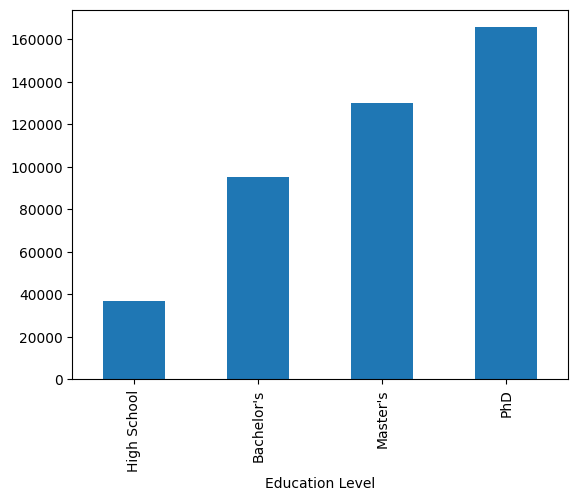

In [24]:
# Combining the education level Bachelor's degree and Bachelor's
df['Education Level'] = df['Education Level'].replace("Bachelor's Degree", "Bachelor's")
df['Education Level'] = df['Education Level'].replace("phD", "PhD")
df['Education Level'] = df['Education Level'].replace("Master's Degree", "Master's")

df['Education Level'].value_counts()
df['Education Level'] = pd.Categorical(df['Education Level'], categories=['High School', 'Bachelor\'s', 'Master\'s', 'PhD'], ordered=True)

df.groupby('Education Level')['Salary'].mean().plot(kind='bar')

In [25]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import joblib

job = 'Software Engineer'
#df_job = df[df['Job Title'] == job]
df_job = df.copy()
df_job = df_job.dropna(subset=['Salary', 'Years of Experience', 'Education Level', 'Gender', 'Age', "Job Title"])

# Encode 'Education Level' for simplicity
education_mapping = {'High School': 0, 'Bachelor\'s': 1, 'Master\'s': 2, 'PhD': 3}
df_job['Education Level'] = df_job['Education Level'].map(education_mapping)

# Encode 'Gender'
gender_mapping = {'Male': 0, 'Female': 1}
df_job['Gender'] = df_job['Gender'].map(gender_mapping)

# Split the data
train, test = train_test_split(df_job, test_size=0.3, random_state=42)
train, val = train_test_split(train, test_size=0.11, random_state=42)

# Create a scaler for features (excluding 'Salary')
feature_scaler = StandardScaler()

# Scale features: 'Years of Experience', 'Age'
train[['Years of Experience', 'Age']] = feature_scaler.fit_transform(train[['Years of Experience', 'Age']])
val[['Years of Experience', 'Age']] = feature_scaler.transform(val[['Years of Experience', 'Age']])
test[['Years of Experience', 'Age']] = feature_scaler.transform(test[['Years of Experience', 'Age']])

# Scale target variable 'Salary' separately
salary_scaler = StandardScaler()
train['Salary'] = salary_scaler.fit_transform(train[['Salary']])
val['Salary'] = salary_scaler.transform(val[['Salary']])
test['Salary'] = salary_scaler.transform(test[['Salary']])

['salary_scaler_rf']

In [26]:
train

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
5107,-0.871098,1.0,2,Content Marketing Manager,-0.678455,-0.673554
6590,1.364455,0.0,1,Content Marketing Manager,1.148915,0.655858
4799,0.706940,1.0,3,Senior Research Scientist,0.816666,0.560900
2166,0.706940,1.0,2,Software Engineer Manager,0.650542,0.845774
1961,-0.871098,0.0,1,Back end Developer,-0.844579,-0.673554
...,...,...,...,...,...,...
1149,-0.476589,1.0,1,Software Engineer,-0.013957,1.225606
4579,0.049424,1.0,2,Director of HR,0.152168,-0.388680
2740,1.101449,0.0,2,Product Manager,0.982791,1.225606
3125,-0.739595,1.0,2,Full Stack Engineer,-0.678455,-0.622334


In [27]:
# Prepare data for PyTorch
# Prepare data for PyTorch
X_train = (train[["Age", "Gender", "Education Level", "Years of Experience"]])
y_train = (train['Salary'])
X_val = (val[["Age", "Gender", "Education Level", "Years of Experience"]])
y_val = (val['Salary'])
X_test = (test[["Age", "Gender", "Education Level",  "Years of Experience"]])
y_test = (test['Salary'])

In [28]:
y_train

5107   -0.673554
6590    0.655858
4799    0.560900
2166    0.845774
1961   -0.673554
          ...   
1149    1.225606
4579   -0.388680
2740    1.225606
3125   -0.622334
617     1.320564
Name: Salary, Length: 4172, dtype: float64

[141636.36363636  88900.90189394  59032.98245614 ... 160000.
 100607.05128205 100886.69340463]
Model Performance:
Test R2: 0.9021979557050694
Test MAE: 9451.518623131344
Test RMSE: 16662.662855849965


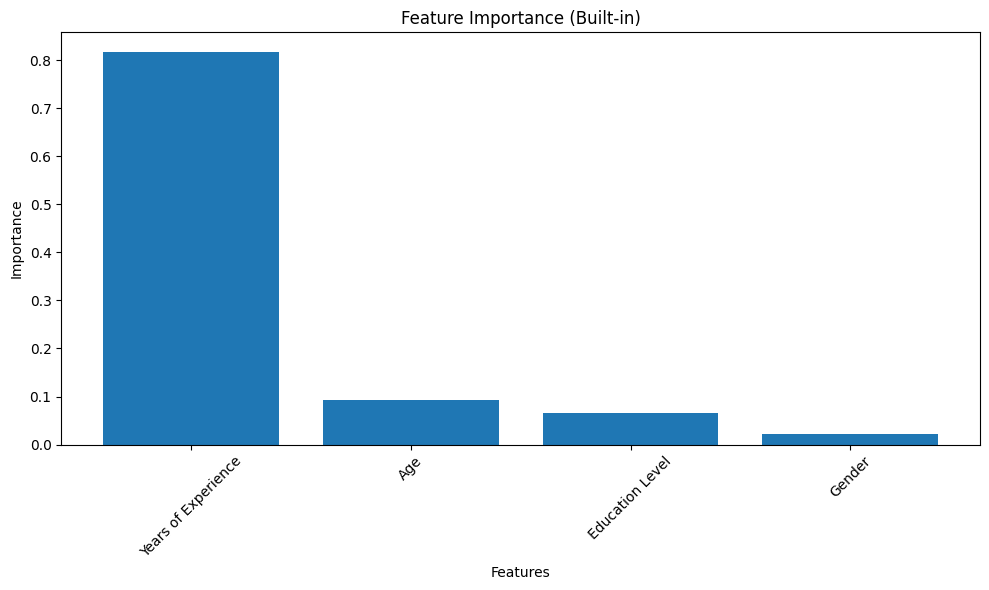

In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import joblib
rf_model = RandomForestRegressor(n_estimators=5, random_state=42)
rf_model.fit(X_train, y_train)



y_pred = rf_model.predict(X_test)

predicted_salaries_unscaled = salary_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
print(predicted_salaries_unscaled)
y_test_unscaled = salary_scaler.inverse_transform(y_test.values.reshape(-1,1)).flatten()

# Calculate accuracy metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Model Performance:")
print("Test R2:", r2_score(y_test_unscaled, predicted_salaries_unscaled))
print("Test MAE:", mean_absolute_error(y_test_unscaled, predicted_salaries_unscaled))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test_unscaled, predicted_salaries_unscaled)))

# 1. Built-in Feature Importance
importances = rf_model.feature_importances_
feature_names = X_train.columns
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.title('Feature Importance (Built-in)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [30]:
#predict on fake data
import joblib
df_fake = pd.DataFrame([
    [27, "Male", "High School", "Software Engineer", 9, 1],
    [27, "Male", "Bachelor's", "Software Engineer",6 , 1],
    [27, "Male", "Master's", "Software Engineer", 4, 1],
    [27, "Male", "PhD", "Software Engineer", 2, 1],
    [28,"Female","Bachelor's","Software Engineer",3,125000]
], columns=["Age", "Gender", "Education Level", "Job Title", "Years of Experience", "Salary"])

education_mapping = {'High School': 0, 'Bachelor\'s': 1, 'Master\'s': 2, 'PhD': 3}
df_fake['Education Level'] = df_fake['Education Level'].map(education_mapping).copy()

# Encode 'Gender'
gender_mapping = {'Male': 0, 'Female': 1}
df_fake['Gender'] = df_fake['Gender'].map(gender_mapping).copy()


# Scale 'Years of Experience', 'Age', and 'Salary' for stability
scaler = joblib.load("C:\Master\ML_theory\Github\ml_project\Salary new dataset\scaler_rf")
df_fake[['Years of Experience', 'Age']] = feature_scaler.transform(df_fake[['Years of Experience', 'Age']])

df_fake = df_fake.drop(columns=["Salary", "Job Title"])
print(df_fake.head())

preds = rf_model.predict(df_fake)

print(preds)

        Age  Gender  Education Level  Years of Experience
0 -0.871098       0                0             0.152168
1 -0.871098       0                1            -0.346206
2 -0.871098       0                2            -0.678455
3 -0.871098       0                3            -1.010704
4 -0.739595       1                1            -0.844579
[ 1.22437745  0.25897031 -0.43925486 -0.00884842 -0.97781934]


In [31]:
predicted_salaries_unscaled = salary_scaler.inverse_transform(preds.reshape(-1, 1)).flatten()

# Add unscaled predicted salaries to the dataframe
df_fake['Predicted Salary (Unscaled)'] = predicted_salaries_unscaled

# Display the updated dataframe
print(df_fake)


        Age  Gender  Education Level  Years of Experience  \
0 -0.871098       0                0             0.152168   
1 -0.871098       0                1            -0.346206   
2 -0.871098       0                2            -0.678455   
3 -0.871098       0                3            -1.010704   
4 -0.739595       1                1            -0.844579   

   Predicted Salary (Unscaled)  
0                179935.335429  
1                129101.957895  
2                 92337.009524  
3                115000.000000  
4                 63978.972418  


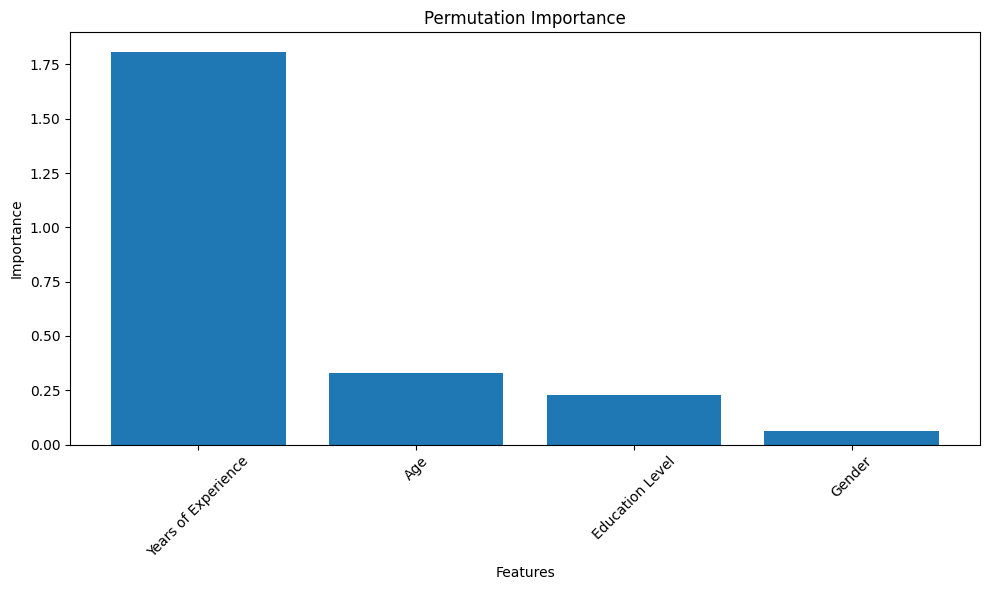

In [32]:
from sklearn.inspection import permutation_importance
# 2. Permutation Importance
perm_importance = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=42)
perm_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': perm_importance.importances_mean
})
perm_importance_df = perm_importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(perm_importance_df['feature'], perm_importance_df['importance'])
plt.title('Permutation Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [33]:
def own_permutation_importance(model, X, y, n_repeats=10):
    baseline_mse = mean_squared_error(y, model(X).detach().numpy())
    importances = []
    
    for col in range(X.shape[1]):
        feature_importances = []
        for _ in range(n_repeats):
            X_permuted = X.clone()
            X_permuted[:, col] = torch.randperm(X.shape[0])
            permuted_mse = mean_squared_error(y, model(X_permuted).detach().numpy())
            importance = permuted_mse - baseline_mse
            feature_importances.append(importance)
        importances.append(np.mean(feature_importances))
    
    return np.array(importances)